# Lagrangian Neural Networks

In this tutorial we take a look at **Lagrangian Neural Networks** (LNNs) [Cranmer M., et al., 2020](https://arxiv.org/abs/2003.04630) which, together with HNNs [link a notebook]() [Greydanus S., et al., 2019](https://arxiv.org/abs/1906.01563) represent the latest learning paradigm to discover symmetries and conservation laws from data.

Let $\mathcal{Q}\subset\mathbb{R}^n$ be a smooth manifold anf let $q\in\mathcal{Q}$ be a vector of generalized coordinates. The Lagrangian function $\mathcal{L}:\mathcal{TQ}\rightarrow\mathbb{R}$ is defined on the tangent bundle $\mathcal{TQ}$ of the configuration manifold $\mathcal{Q}$ (if $\mathcal{Q}=\mathbb{R}^n$, then $\mathcal{TQ}$ is diffeomorphic to $\mathbb{R}^{2n}$), i.e. the Lagrangian is a function of the configurations $q$ and their velocities $\dot q$. 

Derived from the calculus of variations, the Euler-Lagrange equations of motions can be generally explicitly written as a second--order ordinary differential equation:

$$
    \ddot q = \left(\nabla_{\dot q} \nabla_{\dot q}^\top \mathcal{L}\right)^{-1}\left[\nabla_q\mathcal{L} - \left(\nabla_q\nabla^\top_{\dot q}\mathcal L\right)\dot q\right]
$$

**Lagrangian Neural Networks** try to mimick Euler-Lagrange equations by learning from data a Lagrangian $\mathcal{L}_\theta$ parametriezed by a *neural network* (with parameters $\theta$). 

When a net of tuples $\{(q_k,\dot q_k, \ddot q_k)\}_{k=1,\dots,K}$ generated by some conservative dynamical process is available, LNNs are trained to learn the Lagrangian from the data by minimizing, e.g. the *MSE loss*:
$$
    \min_{\theta}\frac{1}{K}\sum_{k=1}^K\left\|\ddot q_k - \left(\nabla_{\dot q} \nabla_{\dot q}^\top \mathcal{L}_\theta(q_k, \dot q_k)\right)^{-1}\left[\nabla_q\mathcal{L}_\theta(q_k, \dot q_k) - \left(\nabla_q\nabla^\top_{\dot q}\mathcal L_\theta(q_k, \dot q_k)\right)\dot q_k\right]\right\|_2^2
$$


We hereby showcase the torchdyn implementation of LNNs.

In [2]:
import sys
sys.path.append('../')
from torchdyn.models import *; from torchdyn.datasets import *
from torchdyn import *

The vector field of an LNN, to be passed to a `NeuralDE` can be defined as:

In [4]:
from torch.autograd.functional import jacobian, hessian ; from functools import partial

class LNN(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.net = net
    def forward(self, x):
        self.n = n = x.shape[1]//2 ; bs = x.shape[0]    
        x = torch.autograd.Variable(x, requires_grad=True)
        qqd_batch = tuple(x[i, :] for i in range(bs))
        jac = tuple(map(partial(jacobian, self._lagrangian, create_graph=True), qqd_batch))
        hess = tuple(map(partial(hessian, self._lagrangian, create_graph=True), qqd_batch))
        qdd_batch = tuple(map(self._qdd, zip(jac, hess, qqd_batch)))
        qd, qdd = x[:, n:], torch.cat([qdd[None] for qdd in qdd_batch])
        return torch.cat([qd, qdd], 1)
    
    def _lagrangian(self, qqd):
        return net(qqd).sum()
    
    def _qdd(self, inp):
        n = self.n ; jac, hess, qqd = inp
        return hess[n:, n:].pinverse()@(jac[:n] - hess[n:, :n]@qqd[n:])

We consider a 1D mass-spring system

$$
    m\ddot x - kx = 0,~~x(0)=0,~~\dot x(0)=1
$$

and we let $q=x$, $p=\dot x$. We then train the neural network on data generated from a single trajectory of the system


## "Static" Training

In [5]:
import torch.utils.data as data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

m, k = 1, 1
X = torch.randn(1000,2).to(device)
Xdd = -k*X[:,0]/m

train = data.TensorDataset(X, Xdd)
trainloader = data.DataLoader(train, batch_size=len(X)//10, shuffle=False)

In [6]:
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        return self.model.defunc(0, x)
    
    def loss(self, y_hat, y):
        return ((y - y_hat[:,1])**2).mean()
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model.defunc(0, x)
        loss = self.loss(y_hat, y)
        return {'loss': loss}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.0001)

    def train_dataloader(self):
        return trainloader

In [8]:
net = LNN(nn.Sequential(
            nn.Linear(2,64),
            nn.Softplus(),
            nn.Linear(64,64),
            nn.Softplus(),
            nn.Linear(64,1))
         ).to(device)

model = NeuralDE(func=net, solver='dopri5', atol=1e-4, rtol=1e-4).to(device)

In [10]:
learn = Learner(model)
trainer = pl.Trainer(min_epochs=500, max_epochs=1000)
trainer.fit(learn)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type     | Params
-----------------------------------
0 | model | NeuralDE | 4 K   
/home/jyp/michael_dev/testenv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


IndexError: tuple index out of range

In [12]:
## Evaluate 
import time

In [18]:
t = time.time()

X0 = torch.randn(100, 2).to(device)
s_span = torch.linspace(0, 1, 20)
traj = model.trajectory(X0, s_span)

print(time.time() - t)

122.33085227012634


In [19]:
traj = traj.cpu().detach()

Text(0.5, 1.0, "HHN's trajectories & training data")

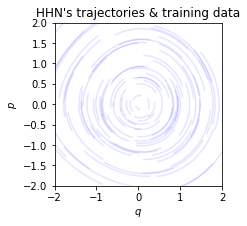

In [20]:
# Plot the HHN's trajectories with random ICs
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
color = ['orange', 'blue']
for i in range(len(X0)):
    ax.plot(traj[:,i,0], traj[:,i,1], color='blue', alpha=0.1);
#ax.plot(X[:,0].cpu(),X[:,1].cpu(), color='red')
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
ax.set_xlabel(r"$q$")
ax.set_ylabel(r"$p$")
ax.set_title("HHN's trajectories & training data")

Text(0.5, 1.0, 'Learned Hamiltonian & Vector Field')

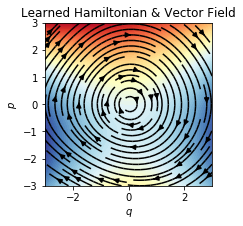

In [21]:
n_grid =  50
x = torch.linspace(-3,3,n_grid)
Q, P = torch.meshgrid(x,x)
H, U, V = torch.zeros(Q.shape), torch.zeros(Q.shape), torch.zeros(Q.shape)
for i in range(n_grid):
    for j in range(n_grid):
        x = torch.cat([Q[i,j].reshape(1,1),P[i,j].reshape(1,1)],1).to(device)
        H[i,j] = model.defunc.m.net(x).detach().cpu()
        O = model.defunc(0,x).detach().cpu()
        U[i,j], V[i,j] = O[0,0], O[0,1]
        
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.contourf(Q,P,H,100,cmap='RdYlBu')
ax.streamplot(Q.T.numpy(),P.T.numpy(),U.T.numpy(),V.T.numpy(), color='black')
ax.set_xlim([Q.min(),Q.max()])
ax.set_ylim([P.min(),P.max()])
ax.set_xlabel(r"$q$")
ax.set_ylabel(r"$p$")
ax.set_title("Learned Hamiltonian & Vector Field")

## HNNs as General-Purpose Modules

If we want to try using using an HNN as a general-purpose DL module, e.g. for a classification task, you can do it well in `torchdyn`. Let us introduce a simple toy example

**Data**

In [ ]:
# Generate data with torchdyn utilities
d = ToyDataset()
X, yn = d.generate(n_samples=520, dataset_type='moons', noise=.4)    

colors = ['orange', 'blue'] 
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
for i in range(len(X)):
    ax.scatter(X[i,0], X[i,1], color=colors[yn[i].int()])

In [ ]:
# Load data into dataloader
X_train = torch.Tensor(X).to(device)
y_train = torch.Tensor(yn.reshape(-1,1)).to(device)

train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=len(X), shuffle=False)

**Learner**

In [11]:
# Define Learner - we will use MSE Loss
class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module, settings:dict={}):
        super().__init__()
        defaults.update(settings)
        self.settings = defaults
        self.model = model
        self.c = 0
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch      
        y_hat = self.model(x)   
        loss = nn.MSELoss()(y_hat, y)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.005)

    def train_dataloader(self):
        return trainloader

In [12]:
# Define Hamiltonian and DEFunc
HamFunc = nn.Sequential(
            nn.Linear(2,64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,1)    
).to(device)

f = DEFunc(nn.Sequential(HNN(HamFunc)))

In [13]:
# Define Neural ODE with Hamiltonian vector field 
settings = {'type':'classic', 'controlled':False, 'solver':'dopri5'}
model = nn.Sequential(
    NeuralDE(f, settings),
    nn.Linear(2,1)
).to(device)
# We append a linear out layer after NeuralDE to use MSE Loss

In [14]:
# Train HNN
learn = Learner(model)
trainer = pl.Trainer(min_nb_epochs=300, max_nb_epochs=600)
trainer.fit(learn)

INFO:lightning:
   | Name                   | Type       | Params
--------------------------------------------------
0  | model                  | Sequential | 4 K   
1  | model.0                | NeuralDE   | 4 K   
2  | model.0.defunc         | DEFunc     | 4 K   
3  | model.0.defunc.m       | Sequential | 4 K   
4  | model.0.defunc.m.0     | HNN        | 4 K   
5  | model.0.defunc.m.0.H   | Sequential | 4 K   
6  | model.0.defunc.m.0.H.0 | Linear     | 192   
7  | model.0.defunc.m.0.H.1 | Tanh       | 0     
8  | model.0.defunc.m.0.H.2 | Linear     | 4 K   
9  | model.0.defunc.m.0.H.3 | Tanh       | 0     
10 | model.0.defunc.m.0.H.4 | Linear     | 65    
11 | model.0.adjoint        | Adjoint    | 0     
12 | model.1                | Linear     | 3     


C:\Users\stefano\Anaconda3\lib\site-packages\pytorch_lightning\utilities\warnings.py:18: RuntimeWarning: Displayed epoch numbers in the progress bar start from "1" until v0.6.x, but will start from "0" in v0.8.0.
  warnings.warn(*args, **kwargs)


1

**Plot Trajectories in the phase space**

In [15]:
s_span = torch.linspace(0, 1, 100)
traj = model[0].trajectory(X_train, s_span).detach().cpu()

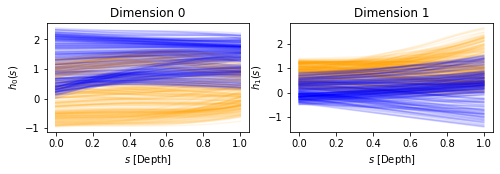

In [16]:
plot_2D_depth_trajectory(s_span, traj, yn, len(X))

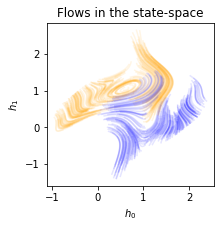

In [17]:
plot_2D_state_space(traj, yn, len(X))

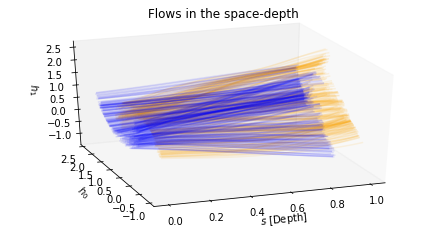

In [18]:
plot_2D_space_depth(s_span, traj, yn, len(X))

**Plot Learned Hamiltonian Function over vector field**

Text(0.5, 1.0, 'Learned Hamiltonian & Vector Field')

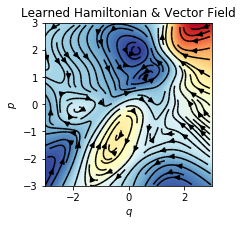

In [19]:
n_grid =  50
x = torch.linspace(-3,3,n_grid)
Q, P = torch.meshgrid(x,x)
H, U, V = torch.zeros(Q.shape), torch.zeros(Q.shape), torch.zeros(Q.shape)
for i in range(n_grid):
    for j in range(n_grid):
        x = torch.cat([Q[i,j].reshape(1,1),P[i,j].reshape(1,1)],1).to(device)
        H[i,j] = model[0].defunc.m[0].H(x).detach().cpu()
        O = model[0].defunc(0,x).detach().cpu()
        U[i,j], V[i,j] = O[0,0], O[0,1]
        
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.contourf(Q,P,H,100,cmap='RdYlBu')
ax.streamplot(Q.T.numpy(),P.T.numpy(),U.T.numpy(),V.T.numpy(), color='black')
ax.set_xlim([Q.min(),Q.max()])
ax.set_ylim([P.min(),P.max()])
ax.set_xlabel(r"$q$")
ax.set_ylabel(r"$p$")
ax.set_title("Learned Hamiltonian & Vector Field")